In [1]:
import os
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import SimpleITK as sitk
from radiomics import featureextractor
import logging
import matplotlib
import matplotlib.colors as mcolors
import scipy.ndimage as ndi
import tqdm


In [2]:
# Set log level for radiomics to suppress warnings
logger = logging.getLogger("radiomics")
logger.setLevel(logging.ERROR)

In [3]:
# Set data paths
brats_dir = "./BraTS2020" 
path_train = os.path.join(brats_dir, "BraTS2020_TrainingData", "MICCAI_BraTS2020_TrainingData")
map_train = pd.read_csv(os.path.join(path_train, "name_mapping.csv"))
surviv_train = pd.read_csv(os.path.join(path_train, "survival_info.csv"))

In [4]:
# Identify the different tissue types
SEGMENT_CLASSES = {
    0: 'non-enhancing solid core',
    1: 'necrotic/cystic core',
    2: 'edema',
    4: 'enhancing core'
}

In [21]:
def create_expanded_mask_multilabel(segmentation, target_volume_increase=50, verbose=False):
    """Creates an expanded segmentation mask, expanding each segment class dynamically.

    Args:
        segmentation (sitk.Image): The original segmentation mask.
        target_volume_increase (float): Percentage increase in volume for each label.
        verbose (bool): If True, logs messages about missing labels and expansion process.

    Returns:
        sitk.Image: The expanded segmentation mask, or the original if an error occurs.
    """
    try:
        segmentation_array = sitk.GetArrayFromImage(segmentation)
        expanded_segmentation_array = np.copy(segmentation_array)  # Initialize with original segmentation

        unique_labels = np.unique(segmentation_array)
        for label in [4, 2, 1]:  # Iterate through tumor labels
            if label not in unique_labels:
                if verbose:
                    print(f"No voxels found with label {label}")
                continue

            mask = segmentation_array == label  # Create binary mask for the current label
            original_volume = np.sum(mask)
            target_volume = original_volume * (1 + target_volume_increase / 100)

            if verbose:
                print(f"Label {label}: Original volume = {original_volume}, Target volume = {target_volume}")

            if original_volume == 0:
                if verbose:
                    print(f"No voxels found with label {label}")
                continue

            iterations = 0
            expanded_mask = mask.copy()

            while np.sum(expanded_mask) < target_volume:
                expanded_mask = ndi.binary_dilation(expanded_mask, iterations=1).astype(int)
                iterations += 1

                # Stop expansion if no further growth is possible
                if np.array_equal(expanded_mask, ndi.binary_dilation(expanded_mask, iterations=1).astype(int)):
                    break

            # Only assign to background (0) areas
            expanded_segmentation_array[np.logical_and(expanded_mask, expanded_segmentation_array == 0)] = label

        expanded_segmentation = sitk.GetImageFromArray(expanded_segmentation_array)
        expanded_segmentation.CopyInformation(segmentation)
        return expanded_segmentation

    except Exception as e:
        print(f"Error creating expanded mask: {e}")
        return segmentation


In [33]:
def extract_features(case_dir, output_csv_original, output_csv_perturbed, volume_increase_percentage=50, verbose=False):
    """Extracts radiomics features from the given case directory and saves them to CSV files."""
    extractor = featureextractor.RadiomicsFeatureExtractor()
    features_list_original = []
    features_list_perturbed = []

    for root, _, files in tqdm.tqdm(os.walk(case_dir), desc="Extracting features", unit="files"):
        seg_files = [f for f in files if f.endswith("seg.nii")]
        if not seg_files:
            continue

        for seg_file in seg_files:
            case_name = "_".join(seg_file.split("_")[:3])
            seg_file_path = os.path.join(root, seg_file)

            # Identify modality files
            modalities = {m: os.path.join(root, f"{case_name}_{m}.nii") for m in ['t1', 't1ce', 't2', 'flair']}
            if not all(os.path.exists(p) for p in modalities.values()):
                print(f"Skipping {case_name} due to missing modalities")
                continue

            segmentation = sitk.ReadImage(seg_file_path)

            # Create perturbed mask only once per case
            perturbed_segmentation = create_expanded_mask_multilabel(
                segmentation, 
                target_volume_increase=volume_increase_percentage, 
                verbose=verbose
            )
            if perturbed_segmentation:
                perturbed_filename = f"{case_name}_seg_perturbed_multi.nii"
                sitk.WriteImage(perturbed_segmentation, os.path.join(root, perturbed_filename))

            # Collect features for all modalities before saving
            case_features_original = []
            case_features_perturbed = []

            for modality, img_path in modalities.items():
                image = sitk.ReadImage(img_path)
                try:
                    # Extract features for original mask
                    features_original = extractor.execute(image, segmentation)
                    case_features_original.append({
                        'case': case_name, 
                        'modality': modality, 
                        'mask_type': 'original',
                        **{k: v for k, v in features_original.items() if k.startswith("original")}
                    })

                    # Extract features for perturbed mask
                    if perturbed_segmentation:
                        features_perturbed = extractor.execute(image, perturbed_segmentation)
                        case_features_perturbed.append({
                            'case': case_name, 
                            'modality': modality, 
                            'mask_type': 'perturbed',
                            **{k: v for k, v in features_perturbed.items() if k.startswith("original")}
                        })

                except Exception as e:
                    print(f"Feature extraction error for {case_name} - {modality}: {e}")
                    continue

            # Append features for the whole case after processing all modalities
            features_list_original.extend(case_features_original)
            features_list_perturbed.extend(case_features_perturbed)

    # Save all features to CSV once, after processing all cases
    pd.DataFrame(features_list_original).to_csv(output_csv_original, index=False)
    pd.DataFrame(features_list_perturbed).to_csv(output_csv_perturbed, index=False)
    print(f"Original features saved to {output_csv_original}")
    print(f"Perturbed features saved to {output_csv_perturbed}")


In [30]:
def plot_segmentations(patient_id, path):
    """Plot the original and perturbed segmentations for a given patient.

    Args:
        patient_id (str): The patient ID to plot.
        path (str): The path to the patient data.
    """

    patient_path = os.path.join(path, patient_id)
    seg = nib.load(os.path.join(patient_path, f"{patient_id}_seg.nii")).get_fdata()
    perturbed = nib.load(os.path.join(patient_path, f"{patient_id}_seg_perturbed_multi.nii")).get_fdata()

    fig, ax = plt.subplots(1, 2, figsize=(10, 7))

    # Plot segmentation with correct colormap and labels
    #cmap = plt.cm.get_cmap("viridis", len(SEGMENT_CLASSES))  # Use a discrete colormap
    colors = ["black", "green", "yellow", "black", "red"]
    cmap = mcolors.ListedColormap(colors)
    im = ax[0].imshow(seg[..., 80], cmap=cmap, vmin=0, vmax=max(SEGMENT_CLASSES.keys())) #set vmin and vmax
    im = ax[1].imshow(perturbed[..., 80], cmap=cmap, vmin=0, vmax=max(SEGMENT_CLASSES.keys())) #set vmin and vmax

    # create patches and get the colors from the colormap
    patches = [matplotlib.patches.Patch(color=cmap(i), label=SEGMENT_CLASSES[i]) for i in SEGMENT_CLASSES if i in np.unique(seg)]
    # Add legend for segmentation labels
    ax[0].set_title("Segmentation")
    ax[0].legend(handles=patches, title="Segmentation", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

    #ax[1].imshow(perturbed[..., 80], cmap="gray")
    ax[1].set_title("Perturbed Segmentation")

    plt.tight_layout() #prevents labels from overlapping
    plt.show()


In [45]:
extract_features(path_train, "features_original.csv", "features_perturbed.csv", volume_increase_percentage=50, verbose=False)

Extracting features: 149files [35:41, 22.68s/files] 

Feature extraction error for BraTS20_Training_099 - t1: Label (1) not present in mask. Choose from [2 4]
Feature extraction error for BraTS20_Training_099 - t1ce: Label (1) not present in mask. Choose from [2 4]
Feature extraction error for BraTS20_Training_099 - t2: Label (1) not present in mask. Choose from [2 4]


Extracting features: 150files [35:42, 16.17s/files]

Feature extraction error for BraTS20_Training_099 - flair: Label (1) not present in mask. Choose from [2 4]


Extracting features: 370files [1:11:56, 11.67s/files]


Original features saved to features_original.csv
Perturbed features saved to features_perturbed.csv


In [47]:
# Create list of patient ids to plot: 
patient_ids = map_train["BraTS_2020_subject_ID"].tolist()
patient_ids = patient_ids[:30] + patient_ids[270:300] # Plot some HGG and LGG patients

Patient ID: BraTS20_Training_001
Grade: HGG


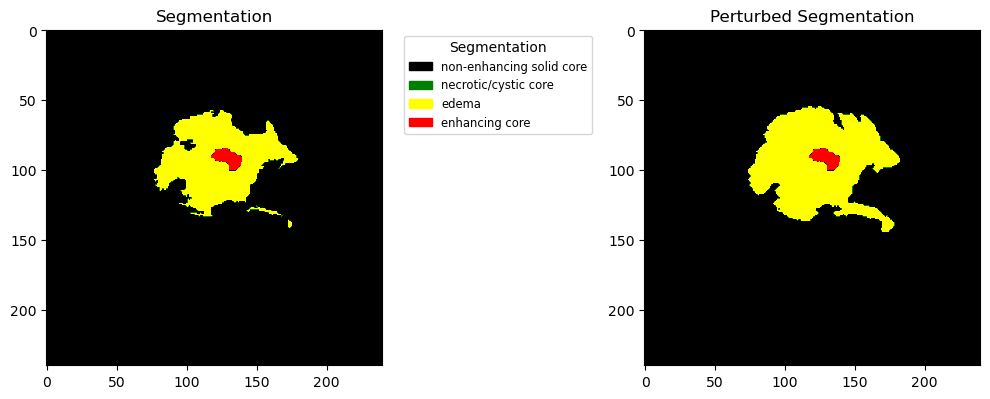

Patient ID: BraTS20_Training_002
Grade: HGG


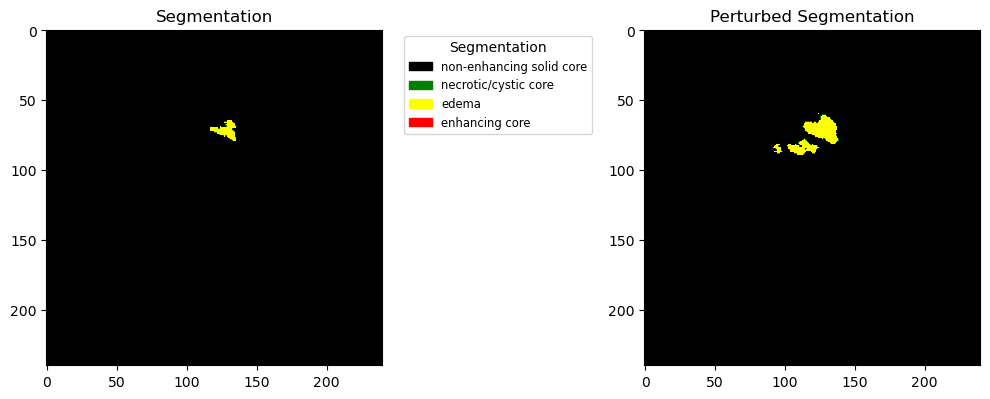

Patient ID: BraTS20_Training_003
Grade: HGG


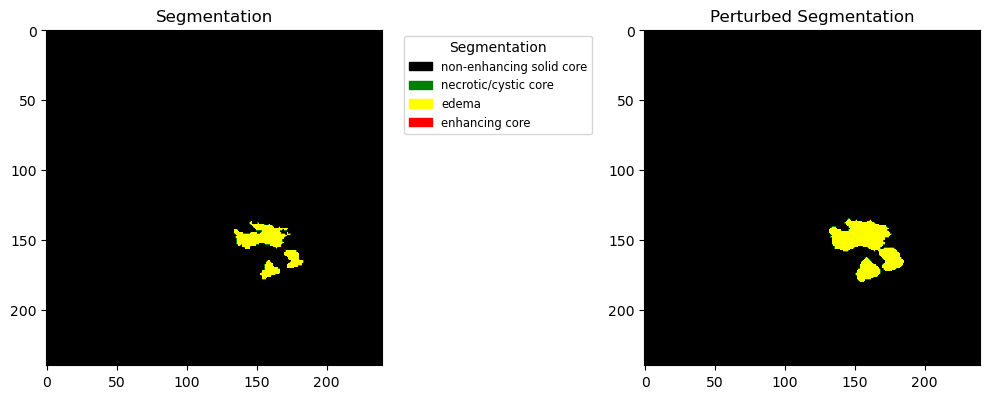

Patient ID: BraTS20_Training_004
Grade: HGG


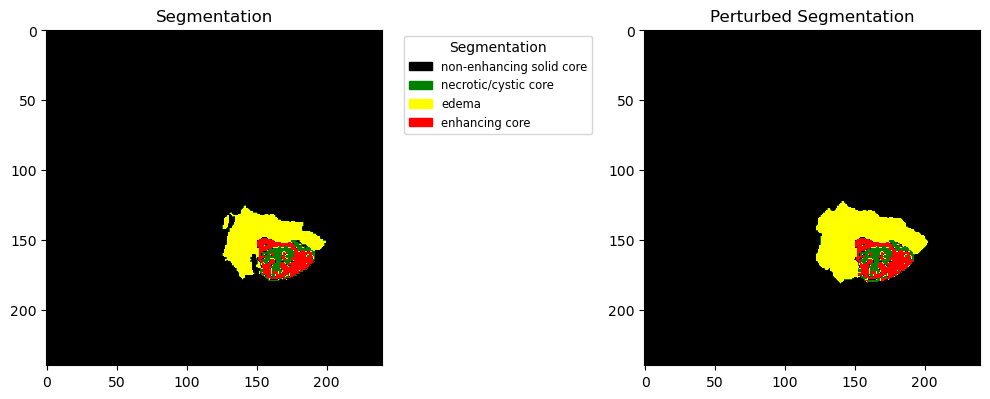

Patient ID: BraTS20_Training_005
Grade: HGG


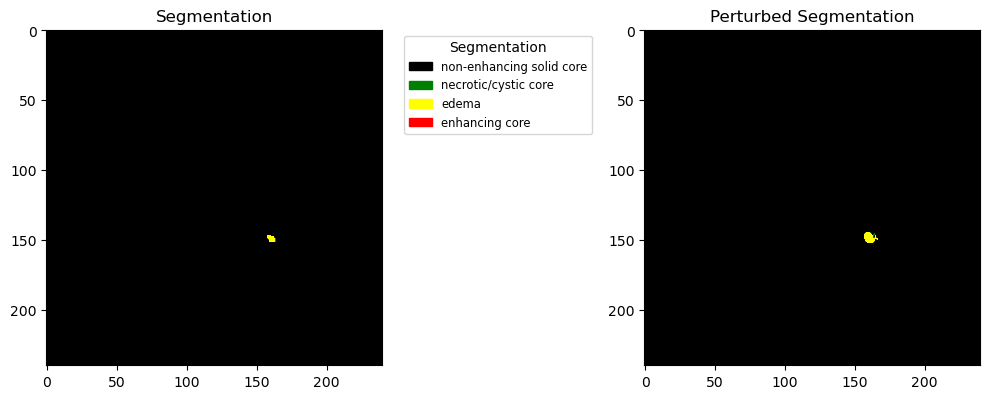

Patient ID: BraTS20_Training_006
Grade: HGG


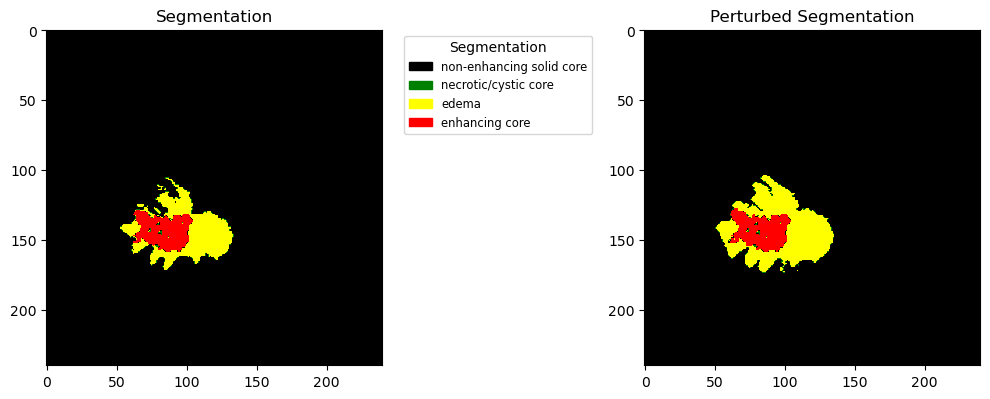

Patient ID: BraTS20_Training_007
Grade: HGG


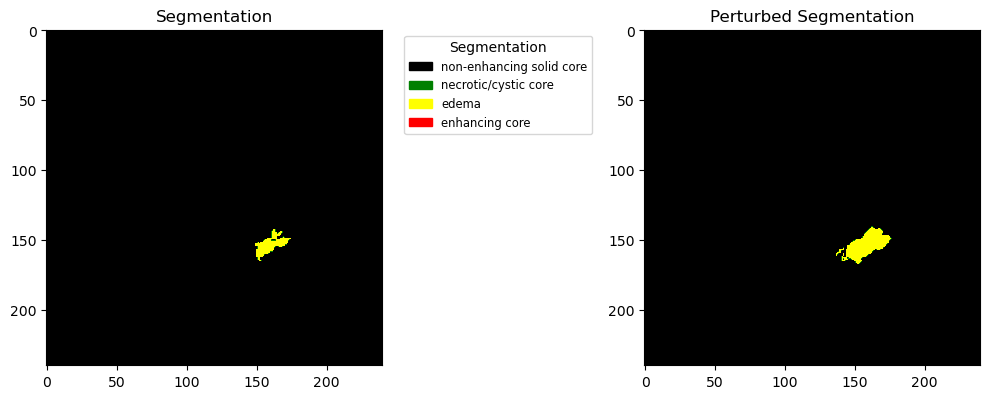

Patient ID: BraTS20_Training_008
Grade: HGG


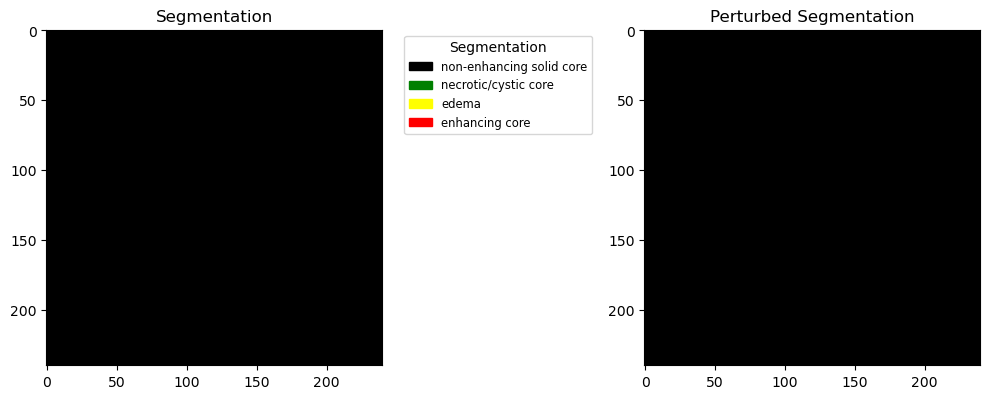

Patient ID: BraTS20_Training_009
Grade: HGG


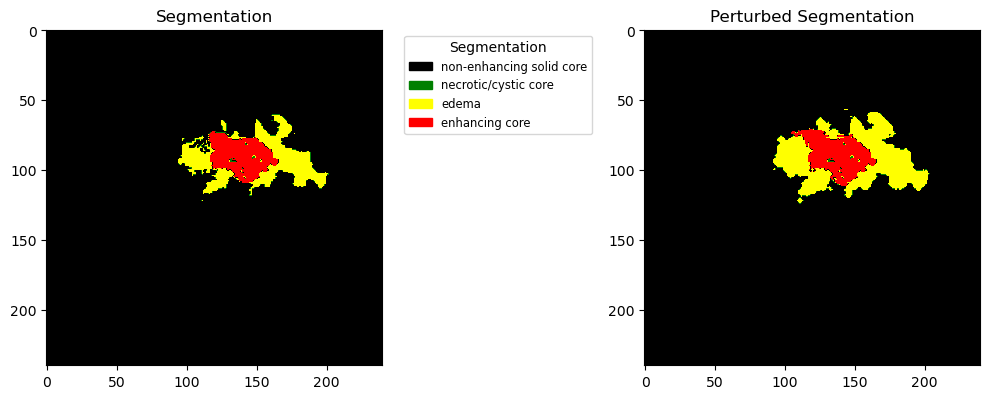

Patient ID: BraTS20_Training_010
Grade: HGG


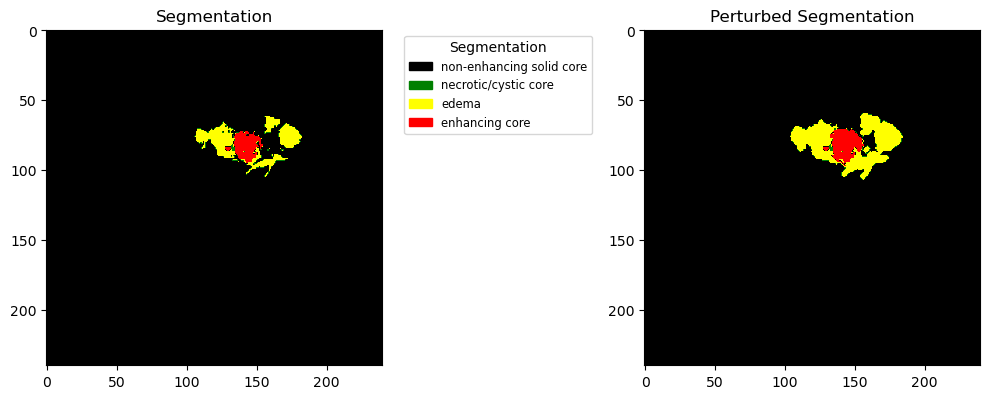

Patient ID: BraTS20_Training_011
Grade: HGG


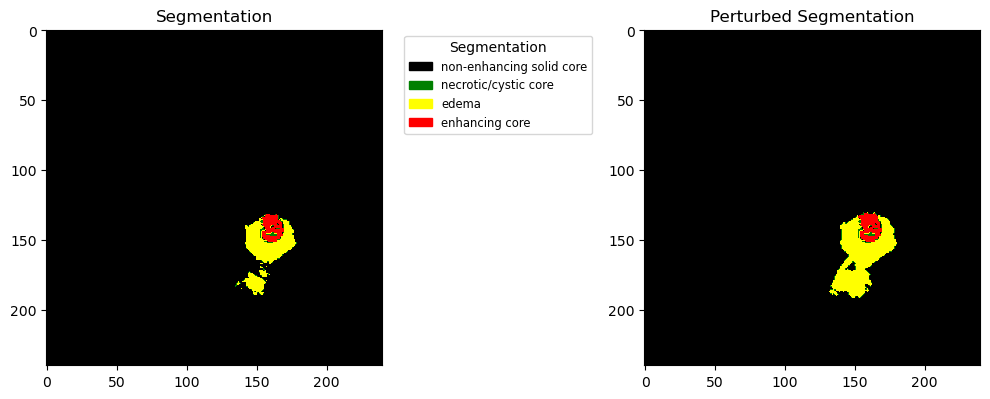

Patient ID: BraTS20_Training_012
Grade: HGG


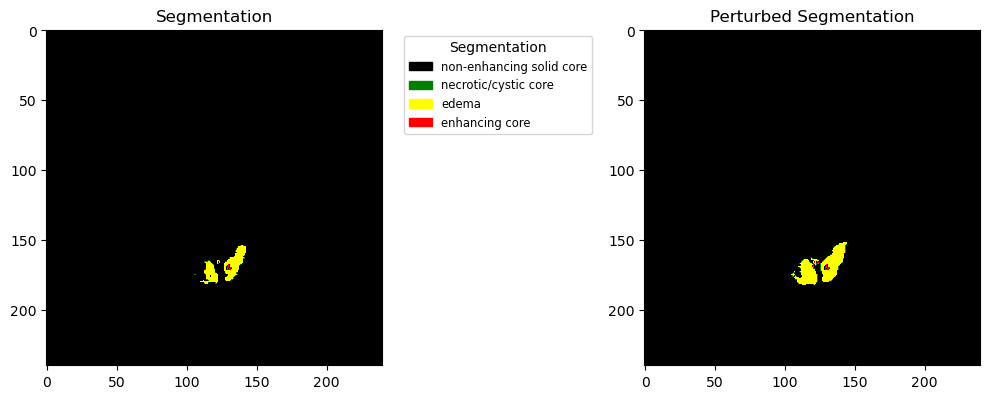

Patient ID: BraTS20_Training_013
Grade: HGG


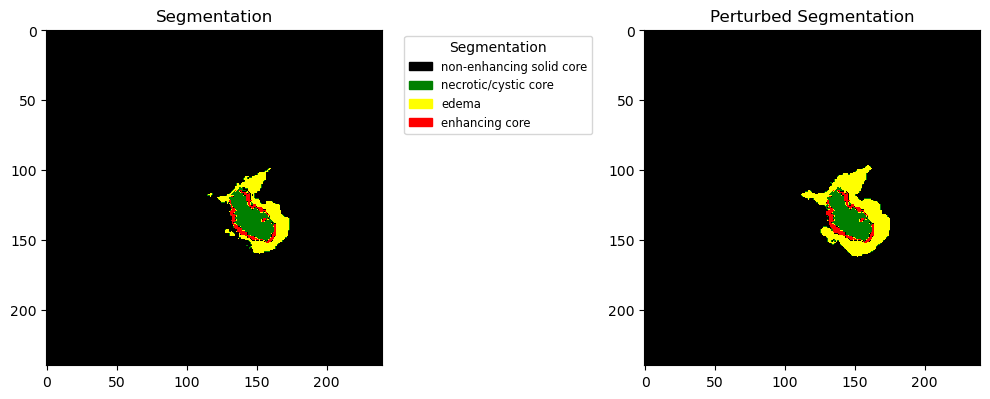

Patient ID: BraTS20_Training_014
Grade: HGG


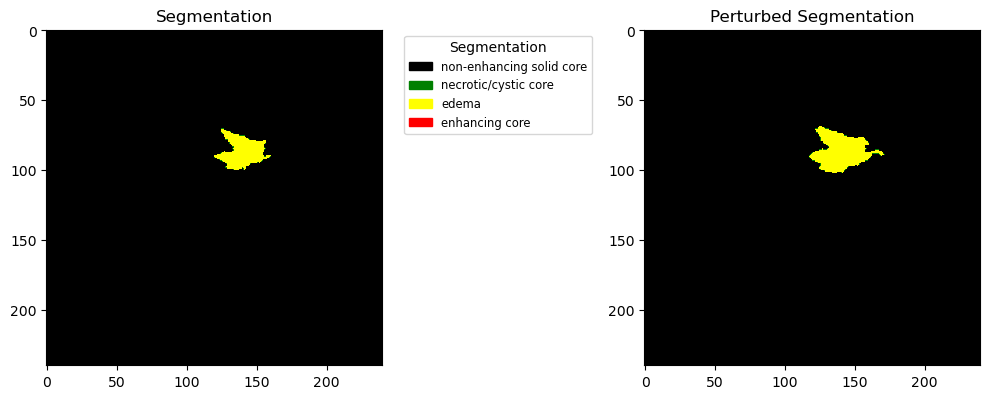

Patient ID: BraTS20_Training_015
Grade: HGG


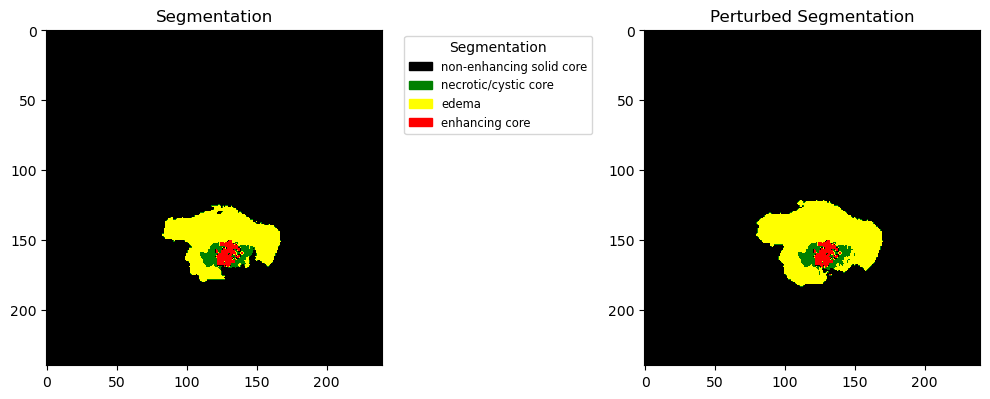

Patient ID: BraTS20_Training_016
Grade: HGG


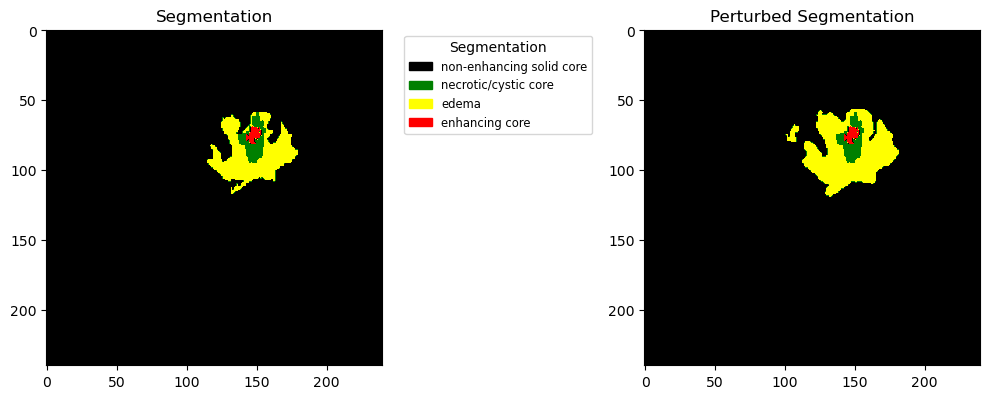

Patient ID: BraTS20_Training_017
Grade: HGG


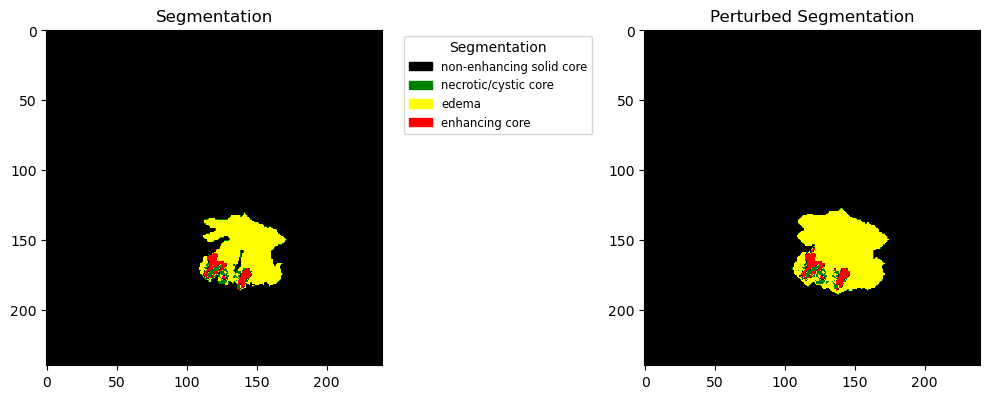

Patient ID: BraTS20_Training_018
Grade: HGG


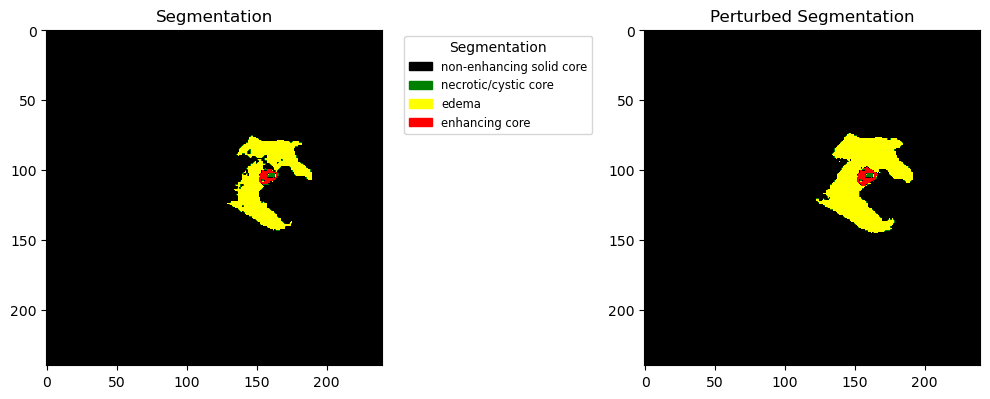

Patient ID: BraTS20_Training_019
Grade: HGG


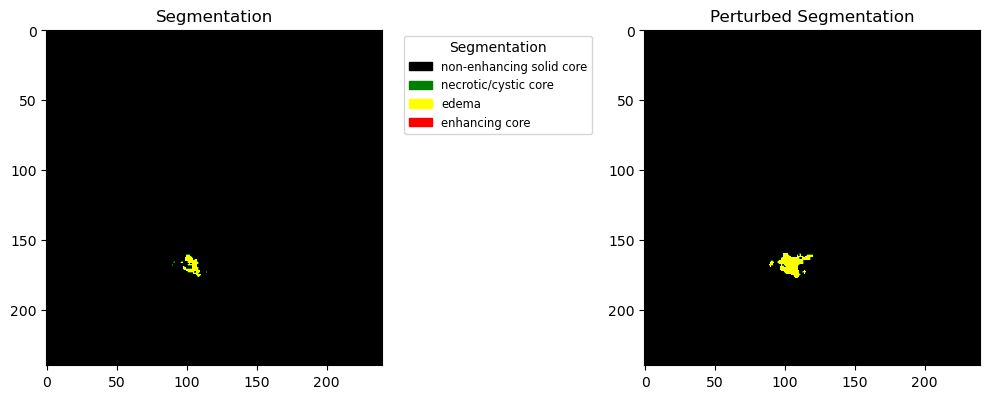

Patient ID: BraTS20_Training_020
Grade: HGG


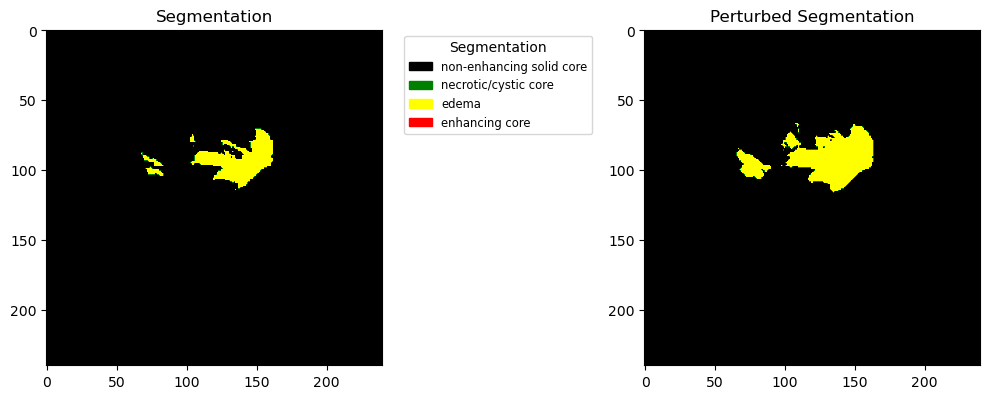

Patient ID: BraTS20_Training_021
Grade: HGG


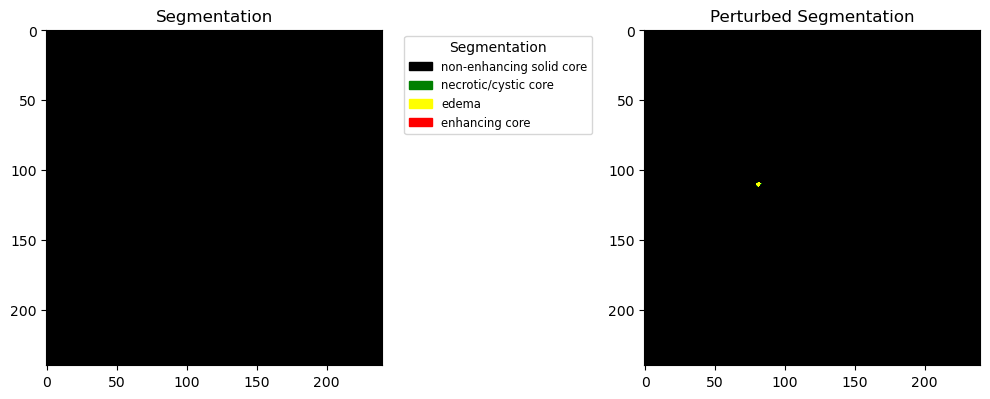

Patient ID: BraTS20_Training_022
Grade: HGG


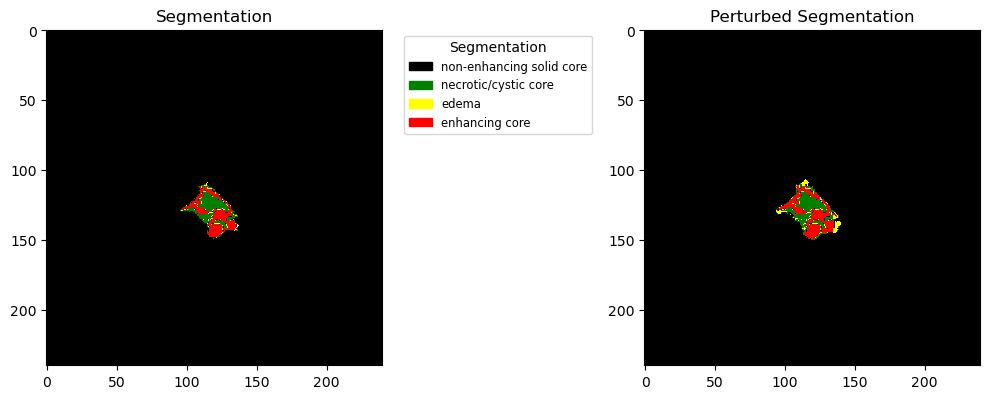

Patient ID: BraTS20_Training_023
Grade: HGG


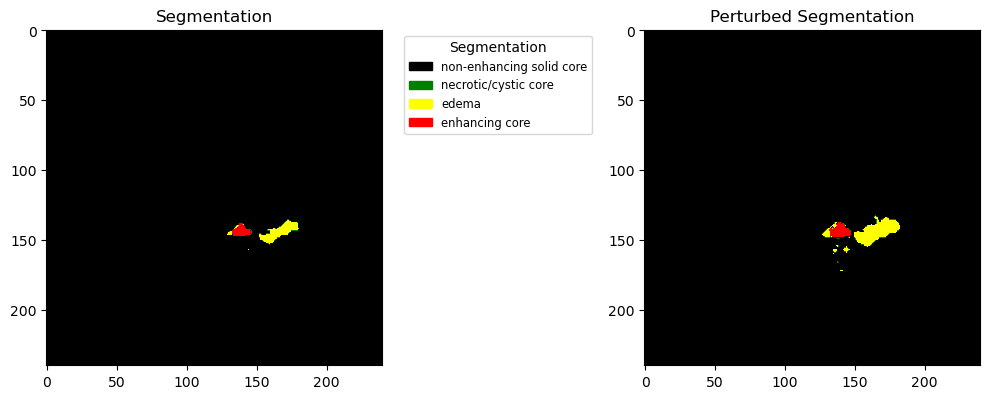

Patient ID: BraTS20_Training_024
Grade: HGG


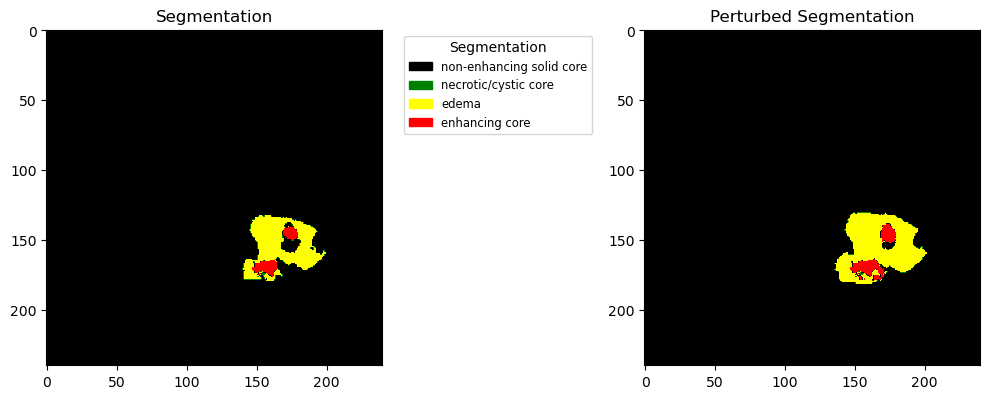

Patient ID: BraTS20_Training_025
Grade: HGG


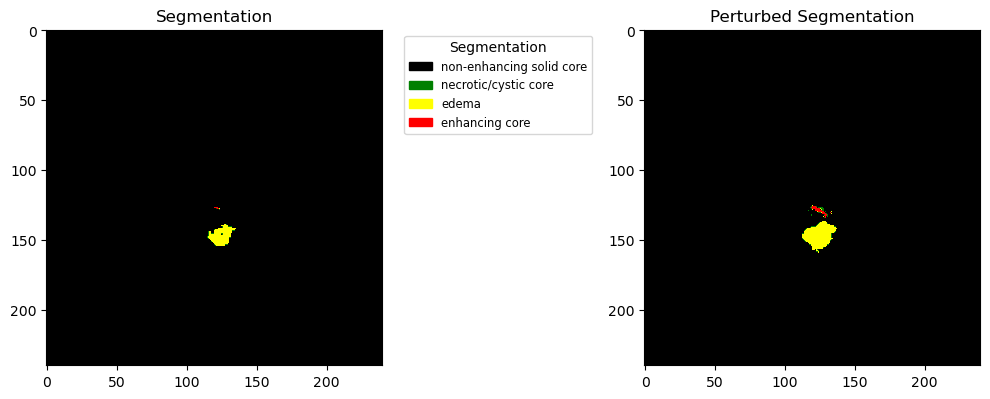

Patient ID: BraTS20_Training_026
Grade: HGG


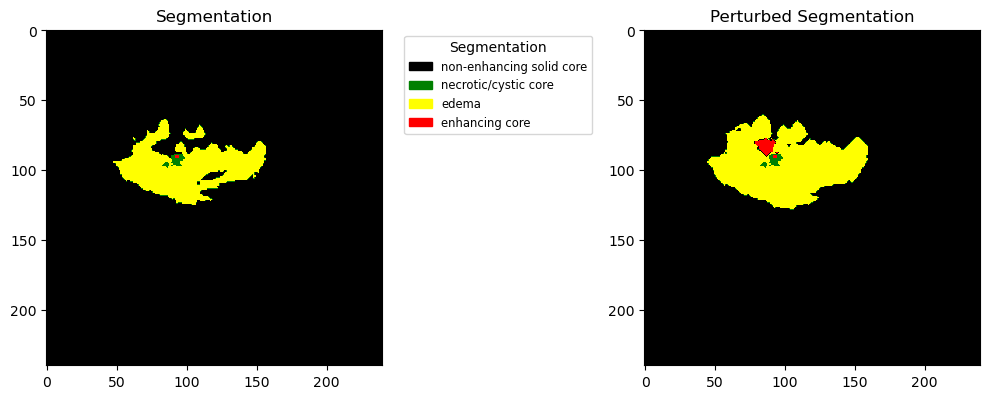

Patient ID: BraTS20_Training_027
Grade: HGG


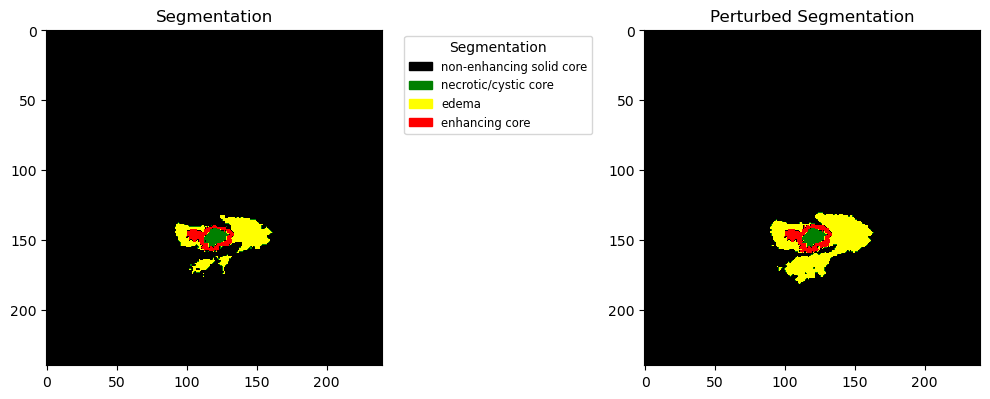

Patient ID: BraTS20_Training_028
Grade: HGG


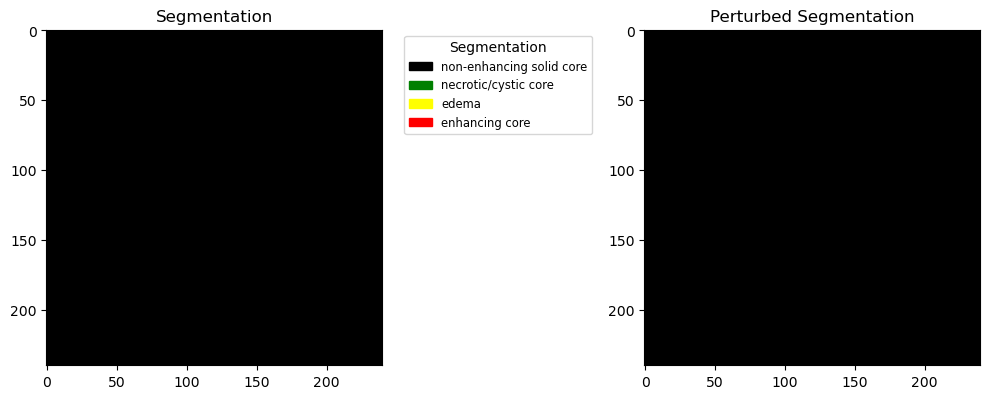

Patient ID: BraTS20_Training_029
Grade: HGG


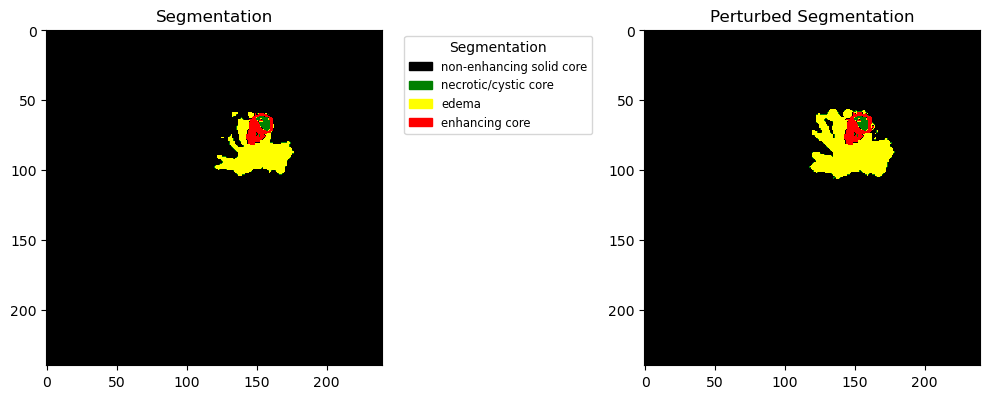

Patient ID: BraTS20_Training_030
Grade: HGG


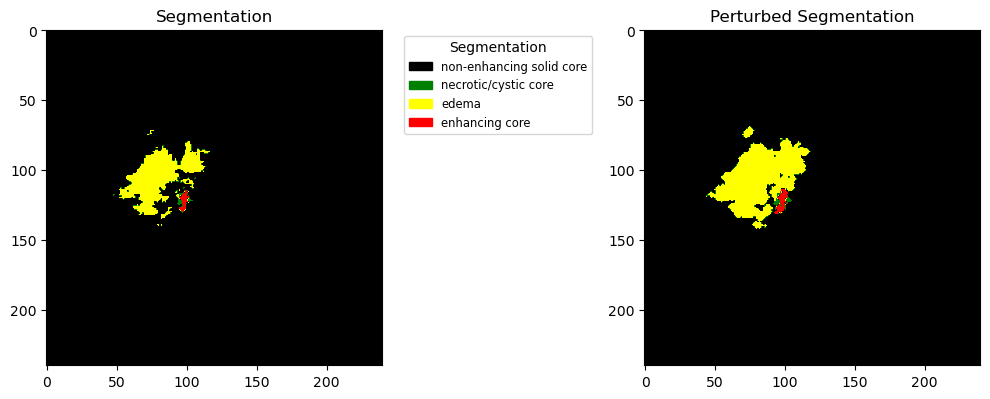

Patient ID: BraTS20_Training_271
Grade: LGG


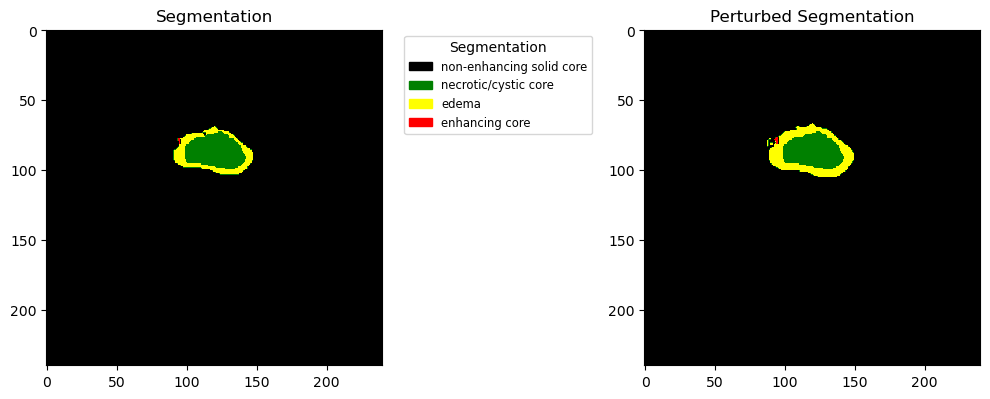

Patient ID: BraTS20_Training_272
Grade: LGG


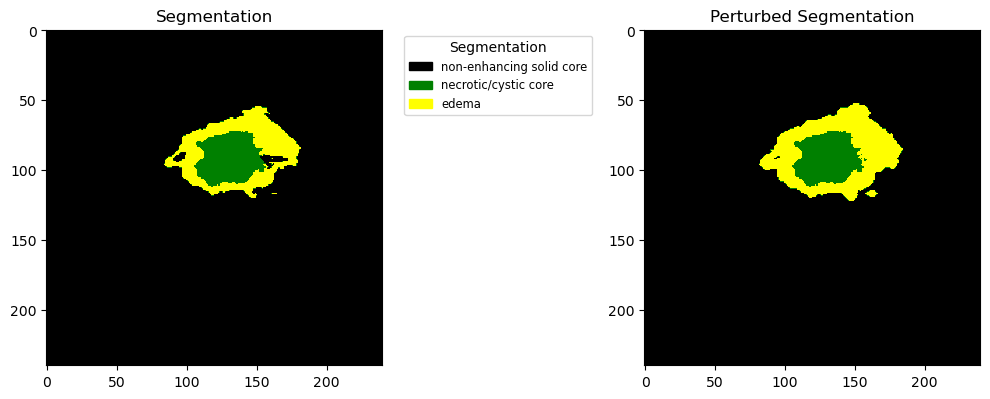

Patient ID: BraTS20_Training_273
Grade: LGG


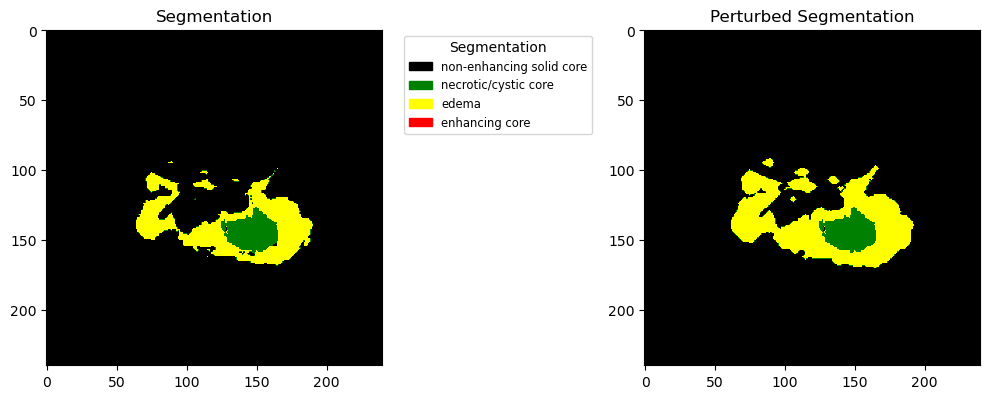

Patient ID: BraTS20_Training_274
Grade: LGG


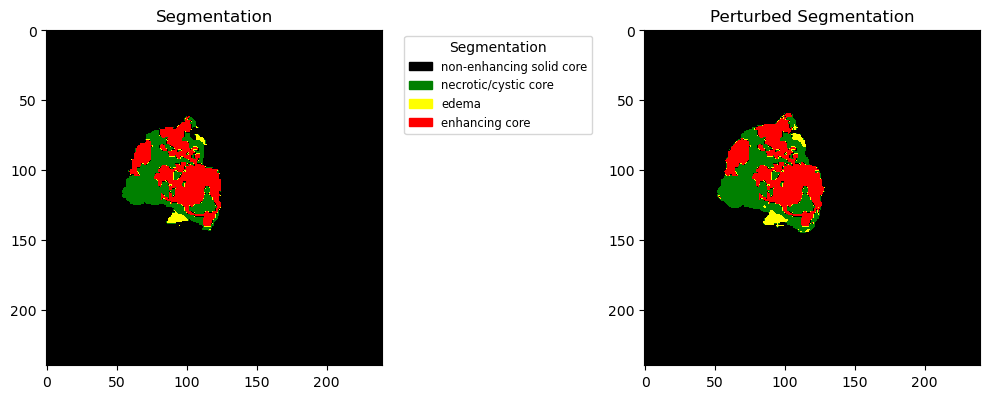

Patient ID: BraTS20_Training_275
Grade: LGG


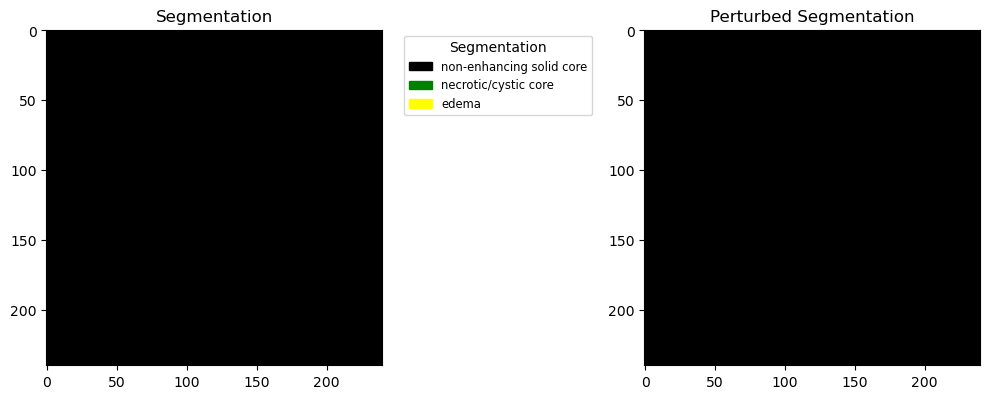

Patient ID: BraTS20_Training_276
Grade: LGG


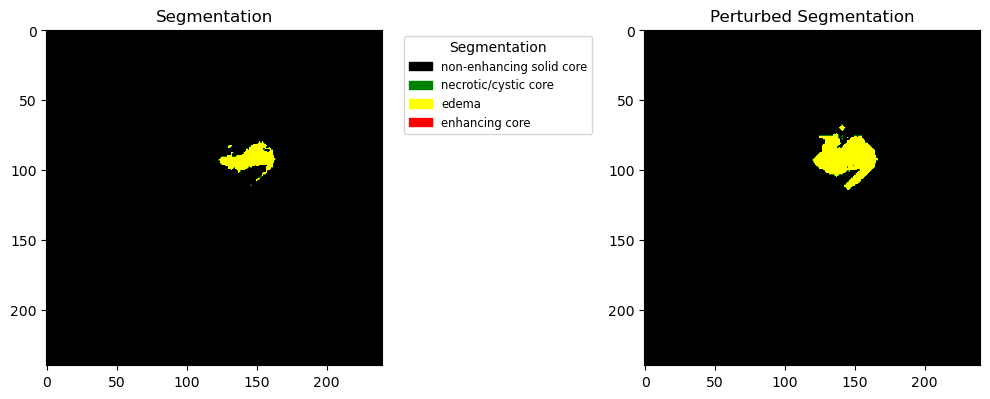

Patient ID: BraTS20_Training_277
Grade: LGG


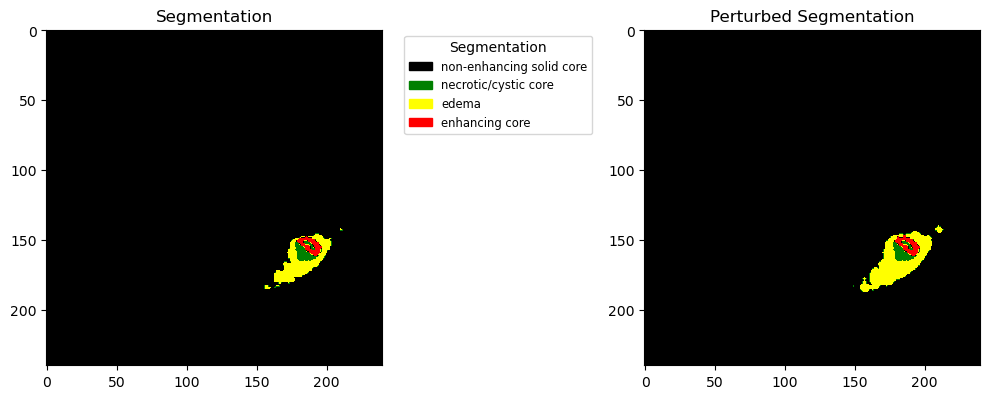

Patient ID: BraTS20_Training_278
Grade: LGG


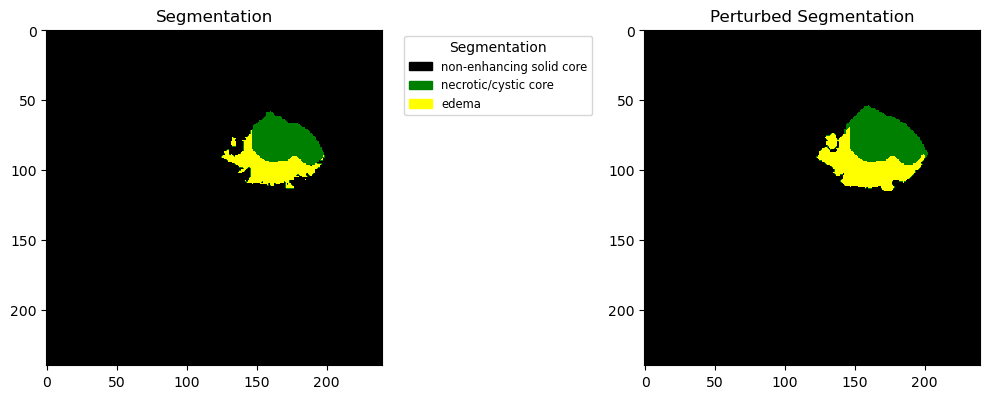

Patient ID: BraTS20_Training_279
Grade: LGG


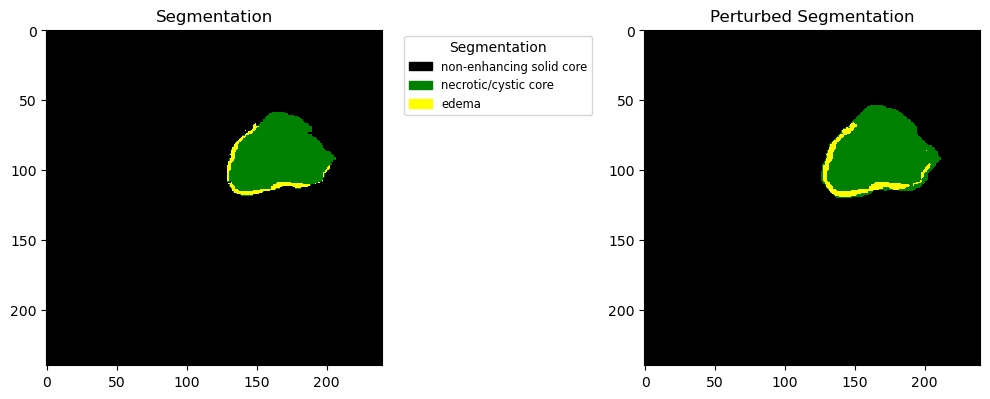

Patient ID: BraTS20_Training_280
Grade: LGG


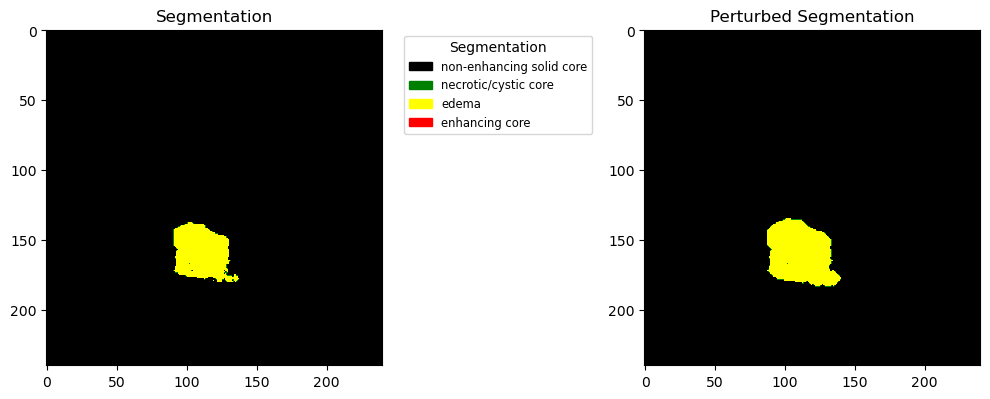

Patient ID: BraTS20_Training_281
Grade: LGG


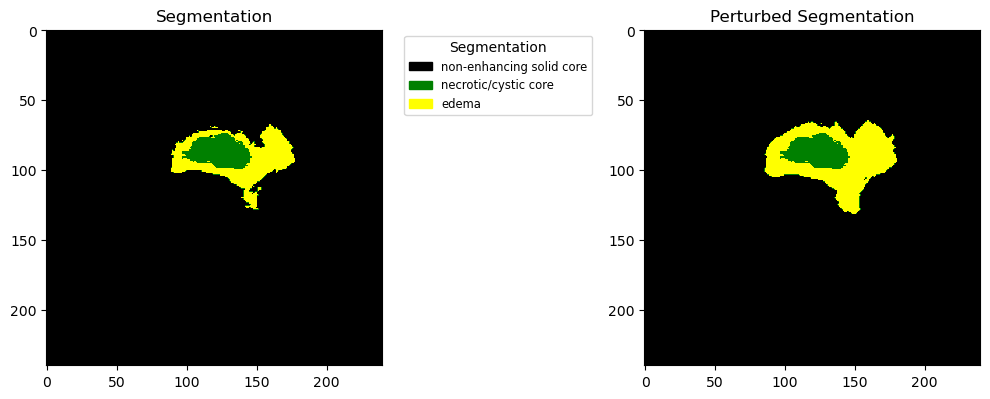

Patient ID: BraTS20_Training_282
Grade: LGG


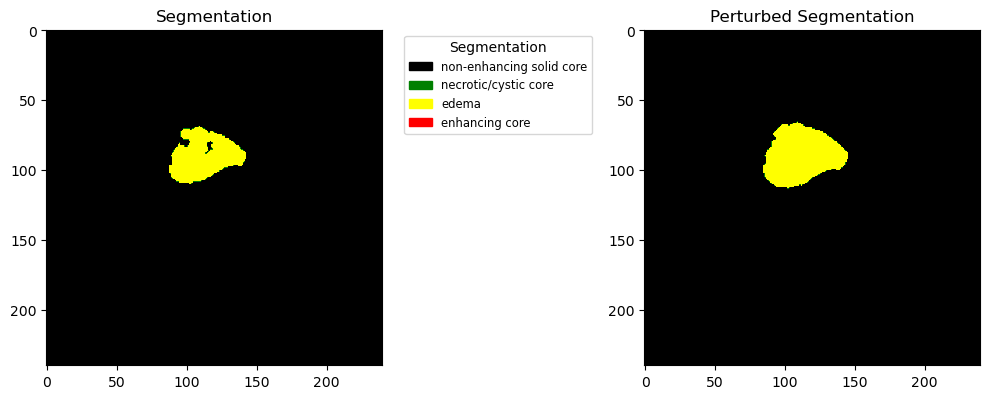

Patient ID: BraTS20_Training_283
Grade: LGG


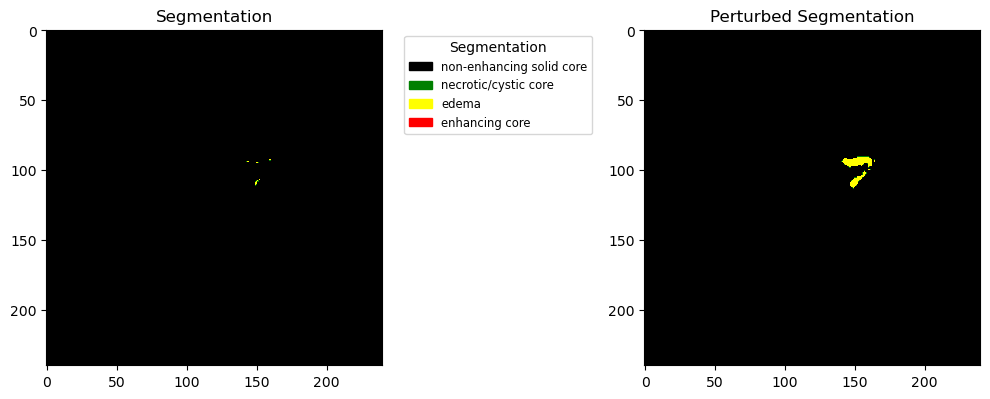

Patient ID: BraTS20_Training_284
Grade: LGG


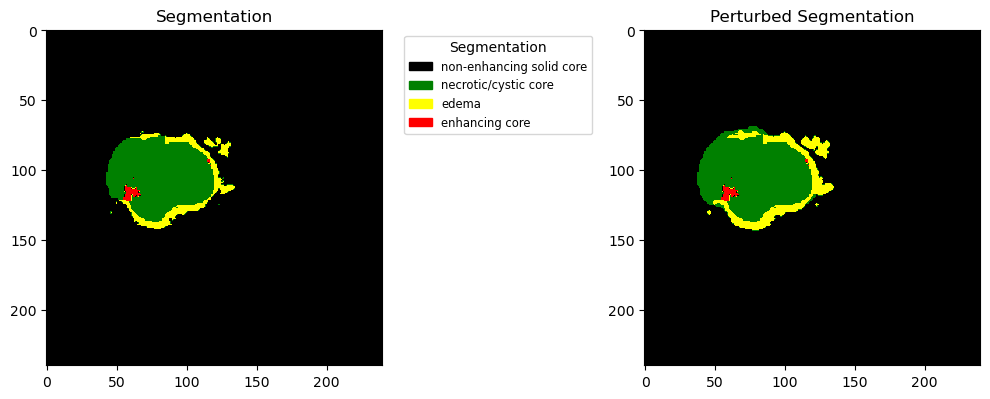

Patient ID: BraTS20_Training_285
Grade: LGG


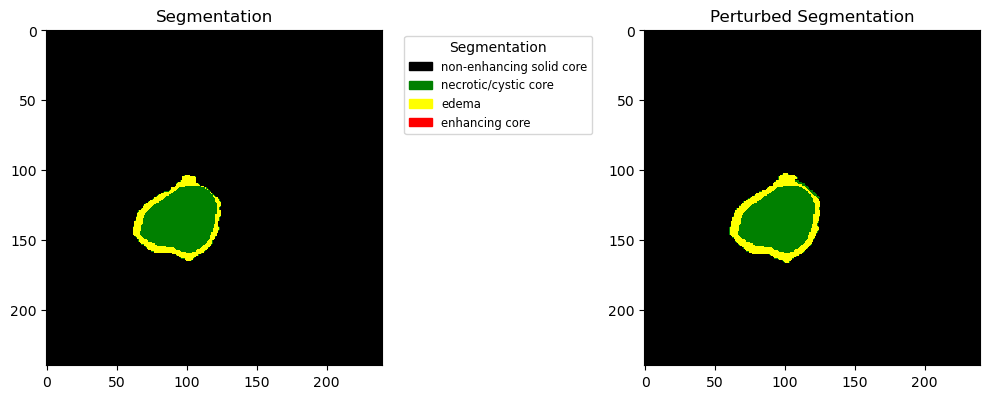

Patient ID: BraTS20_Training_286
Grade: LGG


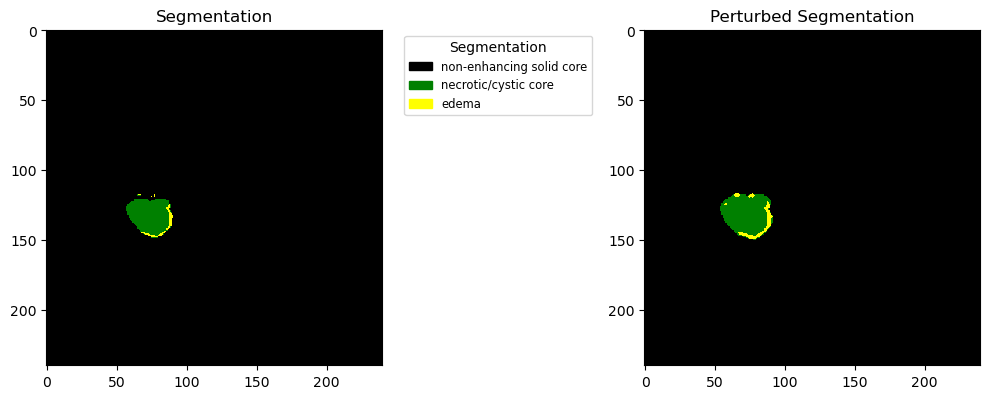

Patient ID: BraTS20_Training_287
Grade: LGG


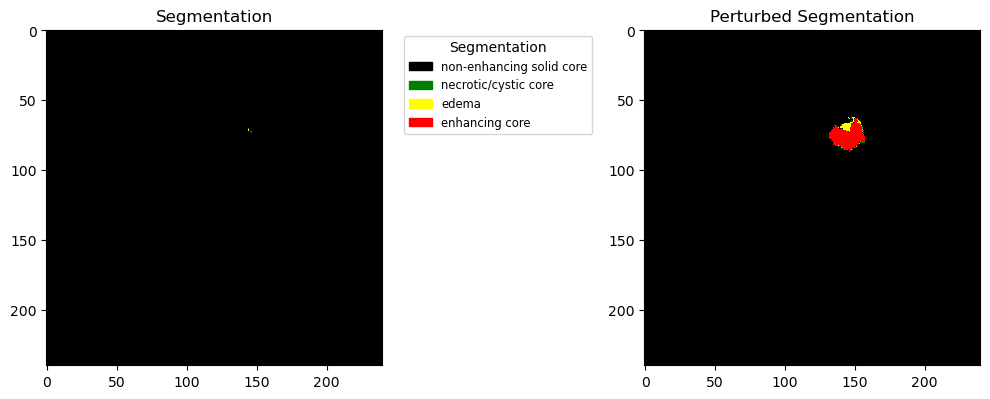

Patient ID: BraTS20_Training_288
Grade: LGG


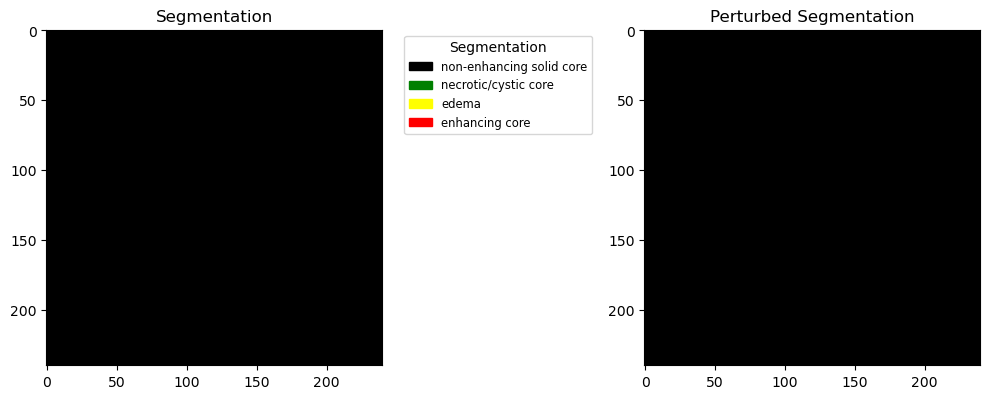

Patient ID: BraTS20_Training_289
Grade: LGG


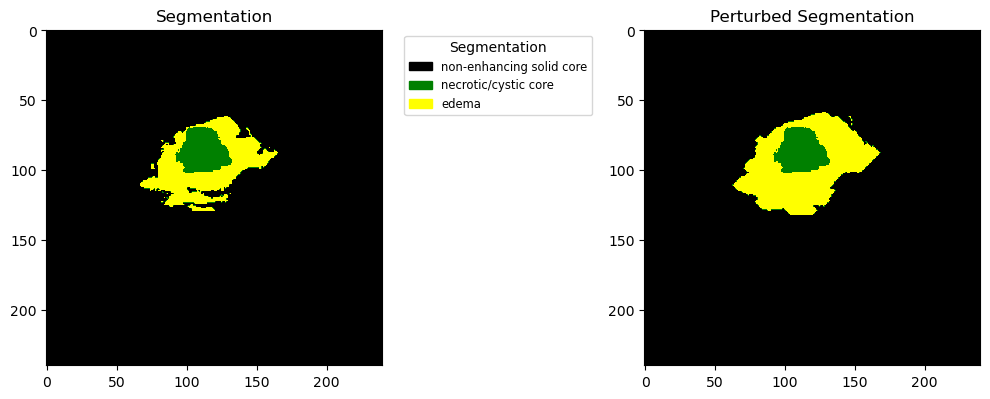

Patient ID: BraTS20_Training_290
Grade: LGG


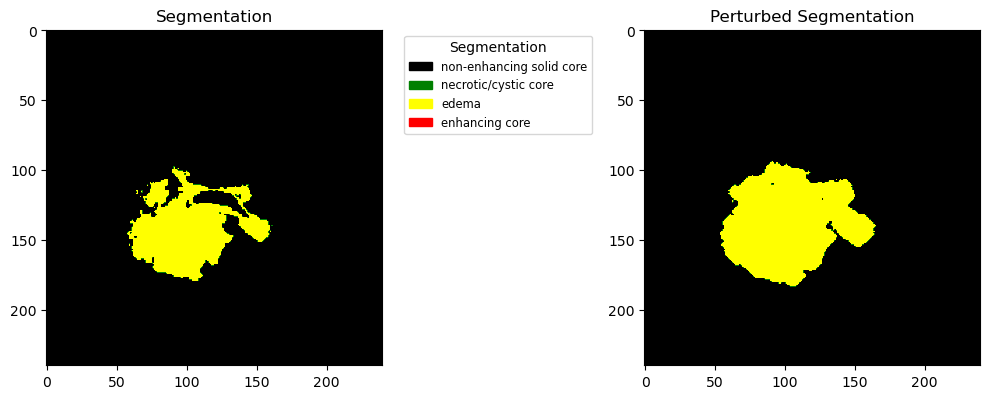

Patient ID: BraTS20_Training_291
Grade: LGG


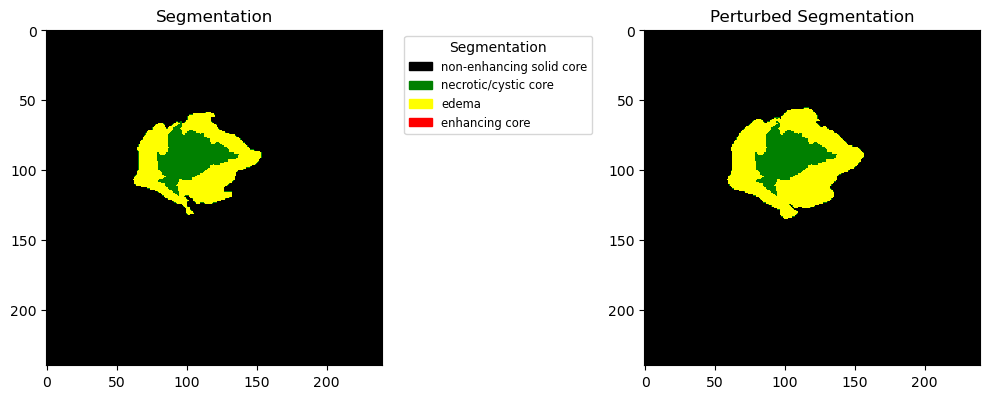

Patient ID: BraTS20_Training_292
Grade: LGG


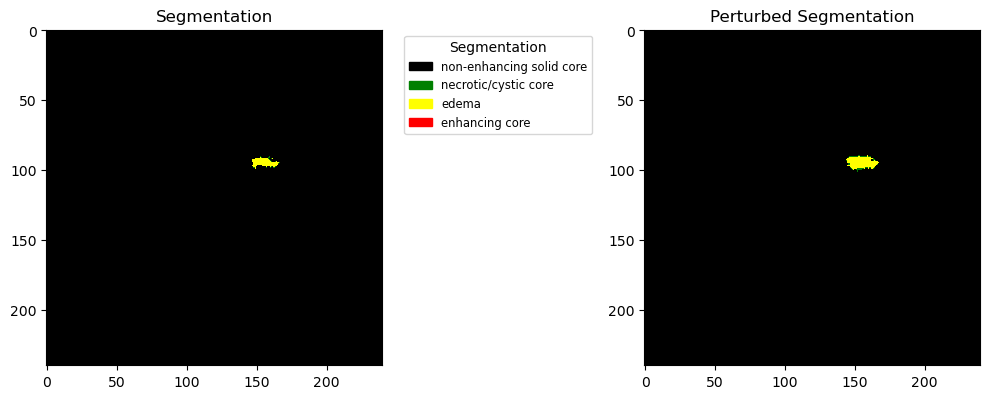

Patient ID: BraTS20_Training_293
Grade: LGG


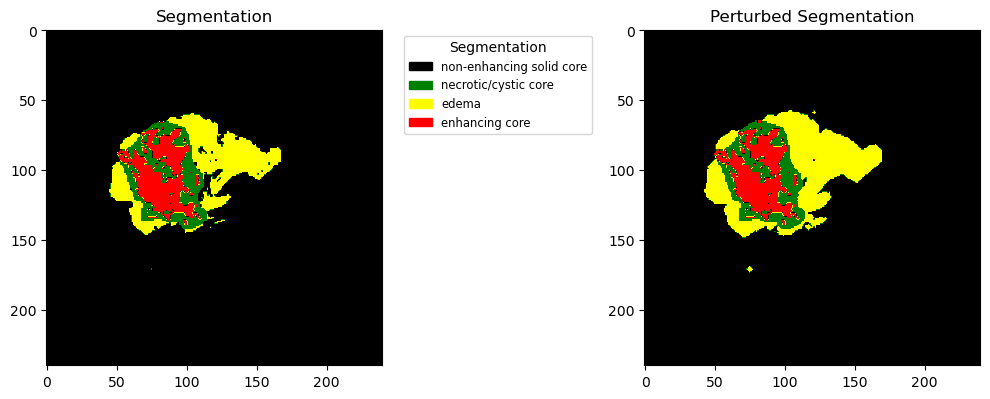

Patient ID: BraTS20_Training_294
Grade: LGG


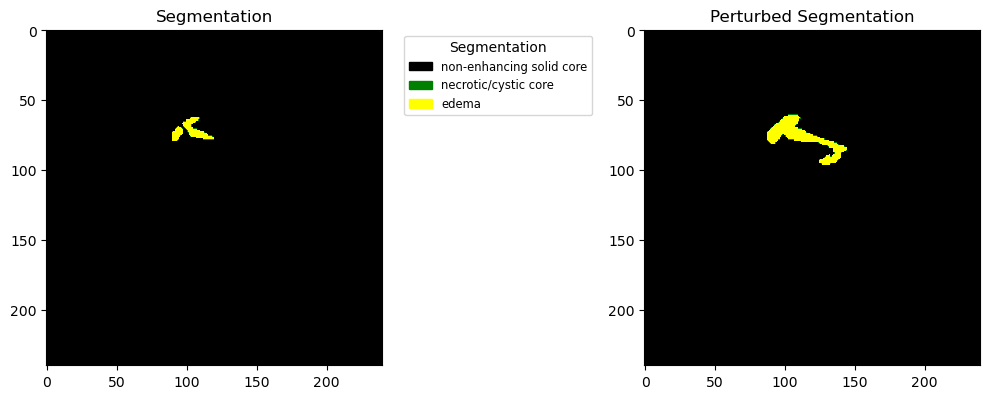

Patient ID: BraTS20_Training_295
Grade: LGG


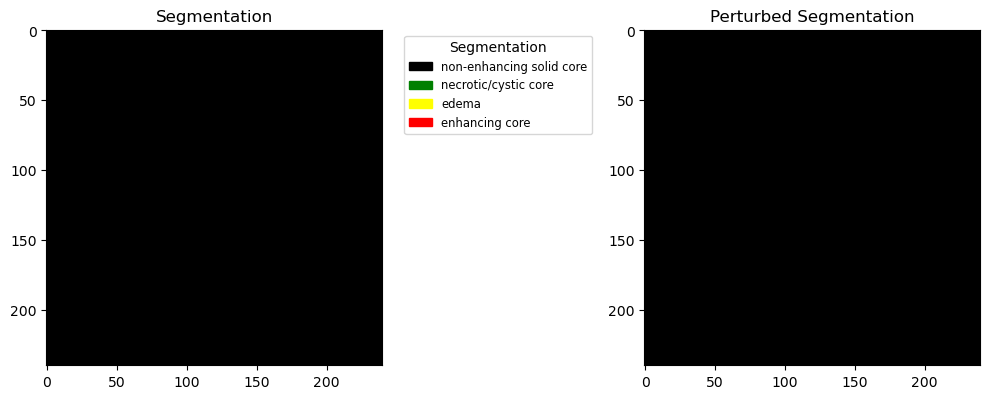

Patient ID: BraTS20_Training_296
Grade: LGG


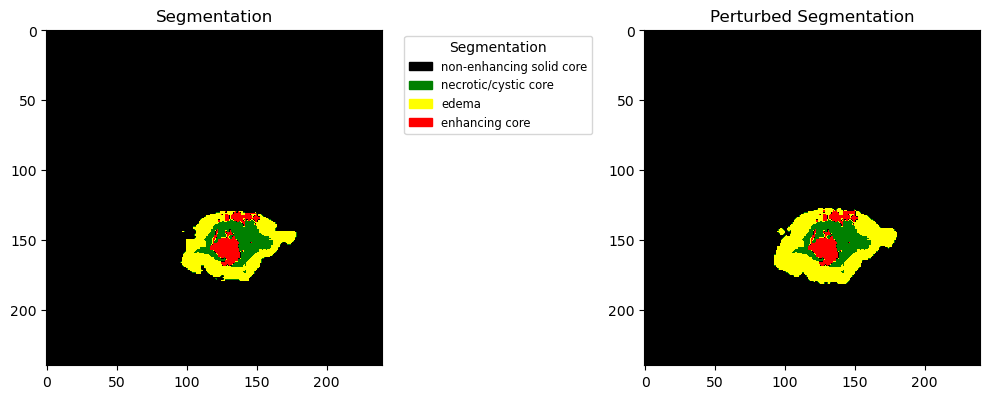

Patient ID: BraTS20_Training_297
Grade: LGG


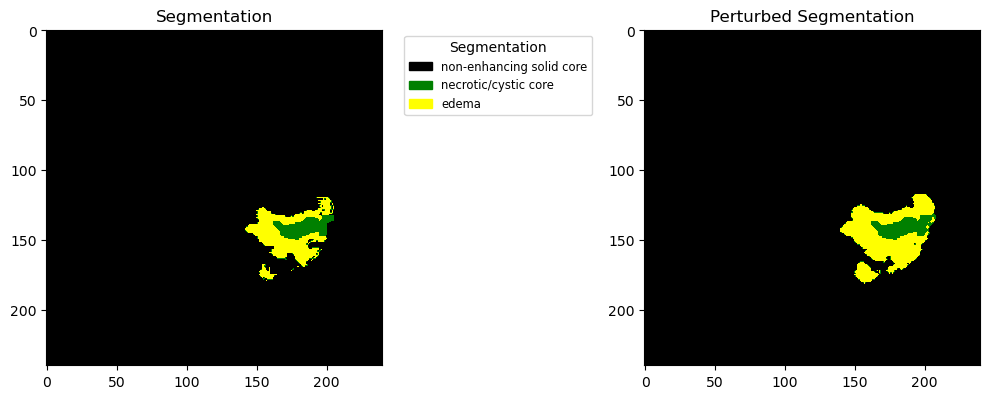

Patient ID: BraTS20_Training_298
Grade: LGG


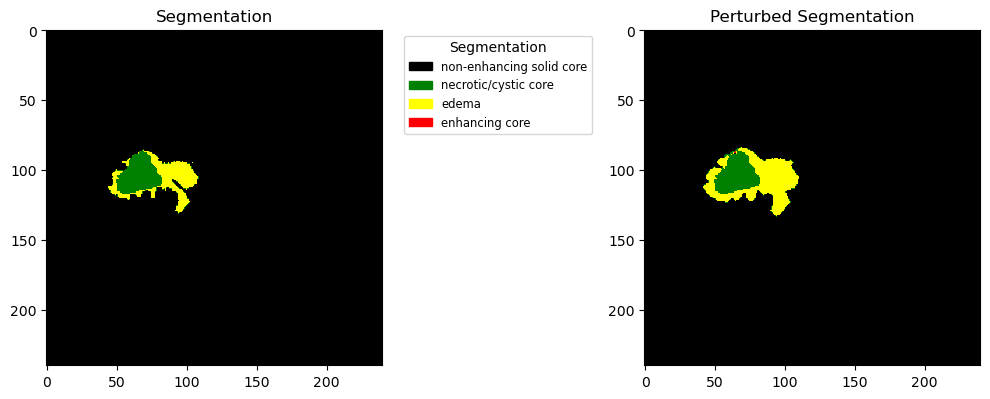

Patient ID: BraTS20_Training_299
Grade: LGG


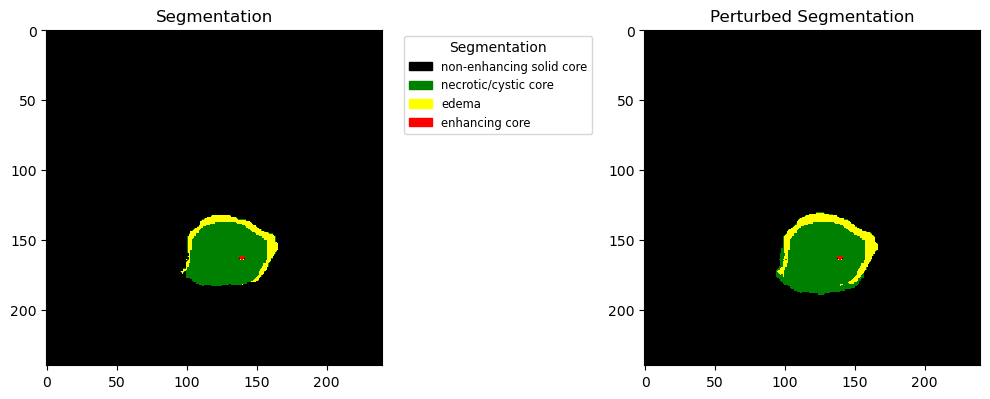

Patient ID: BraTS20_Training_300
Grade: LGG


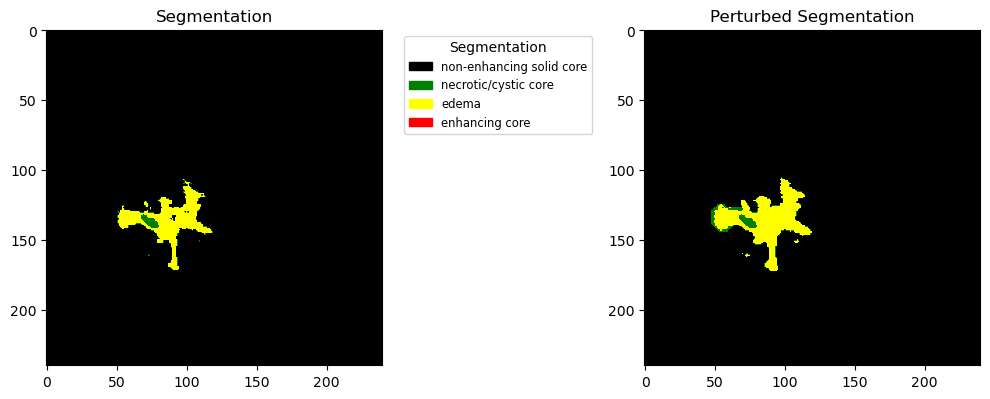

In [48]:
try: 
    for patient_id in patient_ids:
        print(f"Patient ID: {patient_id}")
        print(f"Grade: {map_train[map_train['BraTS_2020_subject_ID'] == patient_id]['Grade'].values[0]}")
        plot_segmentations(patient_id, path_train)
except Exception as e:
    print(f"Error plotting segmentations: {e}")
